In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import torch
import torch.optim as optim
import torch.nn as nn
import datetime
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
class StepByStep(object):
    def __init__(self, model, optimizer, loss_fn):
        super(StepByStep, self).__init__()
        # Arguments
        self.model          = model
        self.optimizer      = optimizer
        self.loss_fn        = loss_fn
        self.device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device         = torch.device('cpu')
        self.model.to(self.device)

        # Placeholders
        self.train_loader   = None
        self.val_loader     = None
        self.writer         = None
        
        # Variables
        self.train_losses   = []
        self.val_losses     = []
        self.total_epochs   = 0

        # Functions
        self.train_step     = self._make_train_step()
        self.val_step       = self._make_val_step()


    def set_loaders(self, train_loader, val_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        suffix = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.writer = SummaryWriter(f'{folder}/{name}-{suffix}')


    def to(self, device):
        self.device = device
        self.model.to(self.device)

    def _make_train_step(self):
        def train_step(x, y):
            # Set model to train mode
            self.model.train()

            # Zero the gradients
            self.optimizer.zero_grad()

            # Forward pass
            yhat = self.model(x)

            # Compute loss
            loss = self.loss_fn(yhat, y)

            # Backward pass, calculate gradients
            loss.backward()

            # Update the parameters
            self.optimizer.step()
            self.optimizer.zero_grad()

            return loss.item()
        return train_step

    def _make_val_step(self):
        def val_step(x, y):
            # Set model to eval mode
            self.model.eval()

            # Forward pass
            yhat = self.model(x)

            # Compute loss
            loss = self.loss_fn(yhat, y)

            return loss.item()
        return val_step


    def _mini_batch(self, validation=False):
        if validation:
            loader = self.val_loader
            step   = self.val_step
        else:
            loader = self.train_loader
            step   = self.train_step

        if loader is None:
            return None

        mini_batch_losses = []

        for x_batch, y_batch in loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            loss_one_batch = step(x_batch, y_batch)
            mini_batch_losses.append(loss_one_batch)
        loss = np.mean(mini_batch_losses)

        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, epochs, seed=42):

        for epoch in range(epochs):

            # Keep track of the numbers of epochs
            self.total_epochs += 1

            # Inner loop
            # Training
            train_loss = self._mini_batch(validation=False)
            self.train_losses.append(train_loss)

            # Validation
            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            if self.writer:
                scalars = {'training': train_loss}
                if val_loss is not None:
                    scalars.update({"validation": val_loss})

                # Records both losses
                self.writer.add_scalars(
                    main_tag='Loss',
                    tag_scalar_dict=scalars,
                    global_step=epoch)
        if self.writer:
            self.writer.flush()


    def save_checkpoint(self, filename):
        checkpoint = {
            'epoch': self.total_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train loss': self.train_losses,
            'val loss': self.val_losses
        }

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary from checkpoint
        checkpoint = torch.load(filename)

        # Restore state for model an optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.total_epochs = checkpoint['epoch']
        self.train_losses = checkpoint['train loss']
        self.val_losses = checkpoint['val loss']

        self.model.train()      # always set to TRAIN mode after loading for resuming training

    def predict(self, x):
        # Set model to eval mode
        self.model.eval()

        # Take numpy and convert it to tensor
        x = torch.from_numpy(x).float()

        # Forward pass
        yhat = self.model(x.to(self.device))

        # Set model back to train mode
        self.model.train()

        # Detach from GPU and convert to numpy, send to CPU and return
        return yhat.detach().cpu().numpy()


    def plot_losses(self):
        fig = plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training loss', c='b')
        
        if self.val_loader is not None:
            plt.plot(self.val_losses, label='Validation loss', c='r')

        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()

        return fig


    def add_graph(self, x):
        if self.train_loader and self.writer:
            x_dummy, y_dummy = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))
            

In [3]:
%run -i ../data_generation/simple_linear_regression.py

In [4]:
# %load data_preparation/v2.py
torch.manual_seed(13)
# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()
# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)
# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val])
# Builds a loader of each set
train_loader = DataLoader(
dataset=train_data,
batch_size=16,
shuffle=True
)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [5]:
%%writefile ../model_configuration/v4.py

# Set learning rate
lr = 1e-2

torch.manual_seed(42)

# Builds model
model = nn.Sequential(nn.Linear(1, 1))

# Builds optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Builds loss function
loss_fn = nn.MSELoss(reduction='mean')

Overwriting ../model_configuration/v4.py


In [6]:
%run -i ../model_configuration/v4.py

In [7]:
model.state_dict()

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])

In [8]:
sbs = StepByStep(model, optimizer, loss_fn)
sbs.set_seed(42)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

2023-02-27 15:24:49.563787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
sbs.model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [14]:
sbs.train(epochs=200)

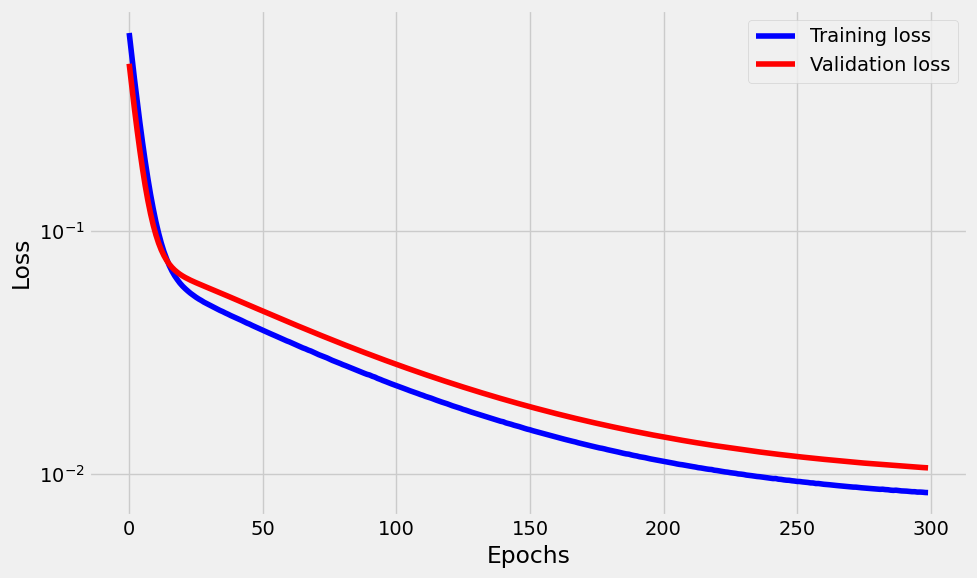

In [15]:
fig = sbs.plot_losses()

In [16]:
# Make prediction
new_data = np.array([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]).reshape(-1, 1)

In [17]:
predictions = sbs.predict(new_data)
predictions

array([[ 3.8383331],
       [ 5.6778097],
       [ 7.517286 ],
       [ 9.356762 ],
       [11.1962385],
       [13.035715 ],
       [14.875192 ],
       [16.714666 ],
       [18.554144 ],
       [20.39362  ]], dtype=float32)

In [21]:
# Checkpointing
! mkdir 'CPFolder'
sbs.save_checkpoint('CPFolder/checkpoint.pth')

mkdir: cannot create directory ‘CPFolder’: File exists


In [22]:
# Resuming Training
%run -i ../model_configuration/v4.py

<Figure size 640x480 with 0 Axes>

In [23]:
new_sbs = StepByStep(model, optimizer, loss_fn)
new_sbs.set_seed(42)
new_sbs.load_checkpoint('CPFolder/checkpoint.pth')
new_sbs.model.state_dict()

OrderedDict([('0.weight', tensor([[1.8395]])), ('0.bias', tensor([1.0791]))])

In [24]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.8395]])), ('0.bias', tensor([1.0791]))])

In [25]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(epochs=100)

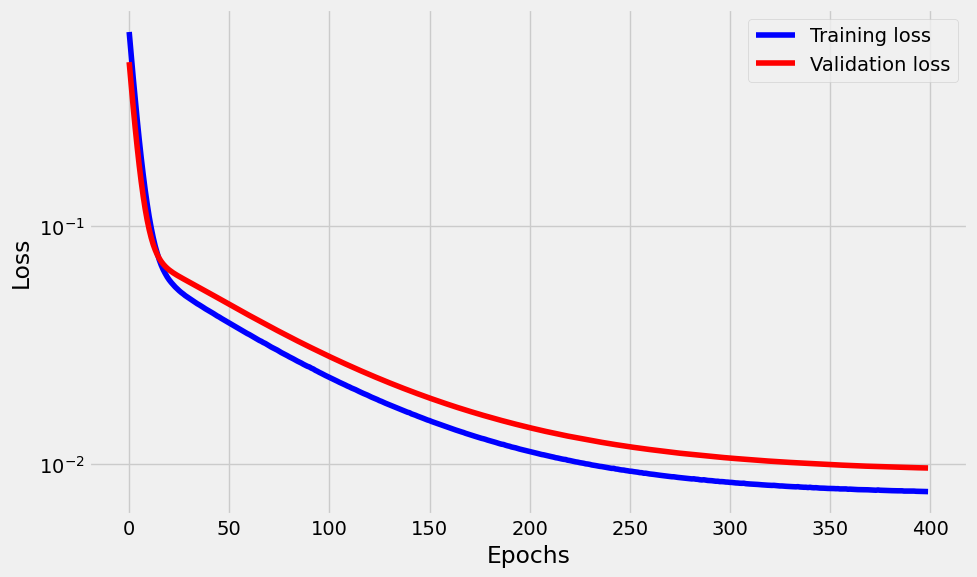

In [26]:
fig = new_sbs.plot_losses()

In [28]:
new_sbs.model.state_dict()

OrderedDict([('0.weight', tensor([[1.8915]])), ('0.bias', tensor([1.0521]))])

In [27]:
sbs.model.state_dict()

OrderedDict([('0.weight', tensor([[1.8395]])), ('0.bias', tensor([1.0791]))])